In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Farmland & Crops Keras EfficientNet

## Import Package


In [1]:
import os
import random
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
# !pip install tf-nightly

In [2]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


## Enabling and testing the TPU

First, you'll need to enable TPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select TPU from the Hardware Accelerator drop-down

Next, we'll check that we can connect to the TPU:

In [3]:
SEED = 5397
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [6]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Mon Oct 31 15:16:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   28C    P0    48W / 400W |    632MiB / 40536MiB |      3%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
     

## Const & Inputs

Here are all of the parameters to change for the run.


In [4]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."
# path = "/content/drive/MyDrive/Colab Notebooks/aidea-farmland-crops-autumn"

# Folder of the training data
training_folder = 'D:/Dataset/aidea-farmland-crops-autumn/train'

# Folder of the public data
public_folder = 'D:/Dataset/aidea-farmland-crops-autumn/public'

# Number of classes in the dataset
num_classes = 2

# Image size for model
image_size = 224

# options: (subset, fullset)
train_mode = 'fullset'

# options: (crop70xy, correct_by_rule, crop70xy_correct_by_rule)
image_preprocessing_method ="crop70xy_correct_by_rule"

# Get the shape of the input layer
input_shape = (image_size, image_size, 3)

In [5]:
tw = ["非作物", "甘藍", "甘藷", "檳榔", "芒果", "竹筍", "茶", "蔥", "木瓜", "太陽麻", "紅豆", "毛豆", "芋", "葡萄", "青花菜", "茭白筍", "絲瓜",
      "荔枝", "龍眼", "韭菜", "狼尾草", "檸檬", "萵苣", "花椰菜", "梨", "田菁", "番荔枝", "百香果", "蓮霧", "結球白菜", "溫網室", "洋蔥", "蘆筍"]
en = ["others", "kale", "sweetpotato", "betel", "mango", "bambooshoots", "tea", "greenonion", "papaya", "sunhemp", "redbeans", "soybeans", "taro", "grape", "broccoli", "waterbamboo", "loofah", "litchi",
      "longan", "chinesechives", "pennisetum", "lemon", "lettuce", "cauliflower", "pear", "sesbania", "custardapple", "passionfruit", "roseapple", "chinesecabbage", "greenhouse", "onion", "asparagus"]
classes_name = pd.DataFrame({"tw": tw, "en": en}).sort_values(by=['en'], ignore_index=True)


In [6]:
association_rules = pd.read_csv(F"{path}/data/association_rules.csv")
association_rules['items'] = association_rules['items'].apply(lambda x: x.replace("frozenset({", "").replace("})", "").replace("'", "").split(", "))
association_items = association_rules.iloc[0]['items']
association_items

['broccoli', 'cauliflower']

## Data Preprocessing

Include: laod data, encode categorical features, split data, normalize data, and save data.


### Load Data
The training set has been randomly split into train (85%) and valid (15%) in advance.

In [74]:
train = pd.read_pickle(F'{path}/data/binary/{train_mode}_train_vector_{image_size}_{image_preprocessing_method}_{association_items[0]}_{association_items[1]}.pkl')
valid = pd.read_pickle(F'{path}/data/binary/{train_mode}_valid_vector_{image_size}_{image_preprocessing_method}_{association_items[0]}_{association_items[1]}.pkl')
test = pd.read_pickle(F'{path}/data/binary/{train_mode}_test_vector_{image_size}_{image_preprocessing_method}_{association_items[0]}_{association_items[1]}.pkl')
data = pd.concat([train, valid, test], ignore_index=True).drop(columns=['vector'])
print(F"data: {data.shape}, train: {train.shape}, valid: {valid.shape}, test: {test.shape}")

data: (5598, 21), train: (3923, 22), valid: (833, 22), test: (842, 22)


### Encode categorical features

OneHotEncoder


In [75]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(data['label'].values.reshape(-1, 1))
train['class'] = list(np.array(enc.transform(train['label'].values.reshape(-1, 1)).toarray().tolist()))
valid['class'] = list(np.array(enc.transform(valid['label'].values.reshape(-1, 1)).toarray().tolist()))
test['class'] = list(np.array(enc.transform(test['label'].values.reshape(-1, 1)).toarray().tolist()))

### Prepare Data
We only need vector and class for training.

In [ ]:
train_vector, train_class = np.array(train['vector'].tolist()), np.array(train['class'].tolist()) 
valid_vector, valid_class = np.array(valid['vector'].tolist()), np.array(valid['class'].tolist()) 
test_vector, test_class = np.array(test['vector'].tolist()), np.array(test['class'].tolist())

## Model Helper
reducelr, tensorboard, checkpoint, earlystop

In [ ]:
def get_reducelr():
    return tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=np.sqrt(0.1),
        patience=10,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
        cooldown=0,
        min_lr=0.5e-7,
    )

In [ ]:
def get_tensorboard(path):
    return tf.keras.callbacks.TensorBoard(log_dir=path)

In [ ]:
def get_checkpoint(model_name, monitor):
    return tf.keras.callbacks.ModelCheckpoint(
        model_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max',
        save_freq='epoch'
    )

In [ ]:
def get_early_stop(patience):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode="min",
        min_delta=0,
        patience=patience,
        restore_best_weights=True
    )

## EfficientNet modelling + training

Using EfficientNetB0~B7.


### Initialize and Reshape the Networks


In [9]:
def get_batch_dataset(train_vector, train_class, valid_vector, valid_class, batch_size):
    train_ds = tf.data.Dataset.from_tensor_slices((train_vector, train_class)).shuffle(5000, seed=5397).batch(batch_size, drop_remainder=True)
    valid_ds = tf.data.Dataset.from_tensor_slices((valid_vector, valid_class)).batch(batch_size, drop_remainder=True)
    return train_ds, valid_ds

In [10]:
def get_augmentation():
    augmentation = tf.keras.models.Sequential()
    # augmentation.add(tf.keras.layers.RandomContrast(factor=0.15))
    # augmentation.add(tf.keras.layers.RandomFlip('horizontal_and_vertical'))
    # augmentation.add(tf.keras.layers.RandomZoom(0.15, 0.15))
    augmentation.add(tf.keras.layers.RandomTranslation(height_factor=0.15, width_factor=0.15))
    augmentation.add(tf.keras.layers.RandomRotation(factor=0.15))
    return augmentation

In [11]:
def get_model(input_shape, num_classes, learning_rate=5e-04, dropout=0.2, isAugmentationActivated=False):
    model = tf.keras.models.Sequential()
    if(isAugmentationActivated):
      model.add(get_augmentation())
    model.add(tf.keras.applications.EfficientNetB7(input_shape=input_shape, include_top=False, weights='imagenet', drop_connect_rate=dropout))
    model.add(tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"))
    model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax', kernel_initializer=tf.keras.initializers.he_uniform(seed=5397), name="pred"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'], run_eagerly=False)
    return model  

In [ ]:
# [10, 30, 50, 100, 150]
EPOCHS = 100

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 32 * strategy.num_replicas_in_sync

# learning rate
LR_START = 4e-04

# dropout rate
DROPOUT = 0.2

# Define model name
model_name = F'{train_mode}_{input_shape[0]}_{image_preprocessing_method}_efficientnetb5_sam_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_reducelr_dropout{int(DROPOUT*100)}_{association_items[0]}_{association_items[1]}'

# Check model is exist
if os.path.exists(F'{path}/models/binary/{model_name}.h5'):
    # stop training if model is exist
    raise SystemExit(F'{model_name} is exist')

### Modelling

In [ ]:
# Dataset to train
train_ds, valid_ds = get_batch_dataset(train_vector, train_class, valid_vector, valid_class, BATCH_SIZE)

In [ ]:
with strategy.scope():    
    # model = get_model(input_shape, num_classes, LR_START, DROPOUT, isAugmentationActivated=False)
    model = tf.keras.models.experimental.SharpnessAwareMinimization(get_model(input_shape, num_classes, LR_START, DROPOUT, isAugmentationActivated=False))
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR_START, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'], run_eagerly=False)

In [ ]:
start = time.time()

# Train model
history = model.fit(
  train_ds,
  epochs=EPOCHS,
  validation_data=valid_ds,
  verbose=2,
  callbacks=[
    get_checkpoint(F'{path}/models/binary/{model_name}.h5', 'val_categorical_accuracy'), 
    get_early_stop(50),
    get_reducelr(),
  ],
)

# Save history
history = pd.DataFrame(history.history)
history.to_csv(F'{path}/logs/binary/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))
# get_batch_dataset_from_generator(test, valid), B0, GPU: 900s
# get_batch_dataset(test, valid), B5, GPU: 600s
# get_batch_dataset(test, valid), B0, TPU: 96s (第 2 個 EPOCH 以後 6s)
# get_batch_dataset(train, valid), B3, TPU: 122s (第 2 個 EPOCH 以後 16s)
# fullset GPU: 835s
# get_batch_dataset(train, valid), B3, GPU: 260s

Epoch 1/100

Epoch 1: val_categorical_accuracy improved from -inf to 0.66146, saving model to /content/drive/MyDrive/Colab Notebooks/aidea-farmland-crops-autumn/models/binary/fullset_224_crop70xy_correct_by_rule_efficientnetb5_sam_epochs100_batchsize256_lr0.0004_reducelr_dropout20_broccoli_cauliflower.h5
15/15 - 251s - loss: 0.7373 - categorical_accuracy: 0.5797 - val_loss: 0.6376 - val_categorical_accuracy: 0.6615 - lr: 4.0000e-04 - 251s/epoch - 17s/step
Epoch 2/100

Epoch 2: val_categorical_accuracy improved from 0.66146 to 0.71875, saving model to /content/drive/MyDrive/Colab Notebooks/aidea-farmland-crops-autumn/models/binary/fullset_224_crop70xy_correct_by_rule_efficientnetb5_sam_epochs100_batchsize256_lr0.0004_reducelr_dropout20_broccoli_cauliflower.h5
15/15 - 15s - loss: 0.6424 - categorical_accuracy: 0.6690 - val_loss: 0.5755 - val_categorical_accuracy: 0.7188 - lr: 4.0000e-04 - 15s/epoch - 998ms/step
Epoch 3/100

Epoch 3: val_categorical_accuracy improved from 0.71875 to 0.769

epochs:  54


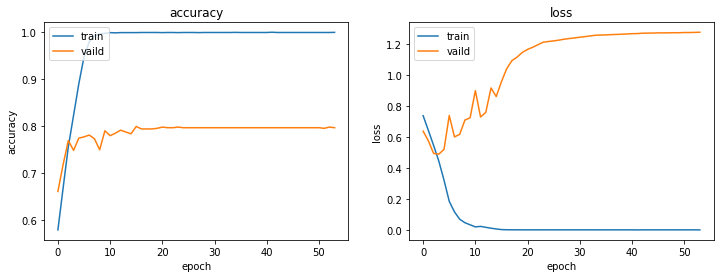

In [ ]:
log = pd.read_csv(F'{path}/logs/binary/{model_name}.csv')
print('epochs: ',len(log))
plt.figure(figsize=(12, 4))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(log['categorical_accuracy'])
plt.plot(log['val_categorical_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(log['loss']) 
plt.plot(log['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Save image
plt.savefig(F'{path}/logs/binary/{model_name}.jpg')

### Prediction of vaild
Prediction based on the best model during training

In [12]:
from sklearn.metrics import classification_report

def evaluate(y_true, y_pred,zero_division = 1):
    labels = sorted(list(set(y_true + y_pred)))
    eval_result = classification_report(
        y_true, y_pred, target_names=labels, 
        output_dict=True, zero_division=zero_division
    )
    return eval_result

In [ ]:
# # Load model with the best validation accuracy
# with strategy.scope():    
#     model = get_model(input_shape, num_classes)
#     model.load_weights(F'{path}/models/binary/{model_name}.h5')
#     # model.load_weights(F'{path}/models/{best_model}.h5')

In [ ]:
# Predict the response for train dataset
train['predict'] = list(model.predict(train_vector, verbose=1))
train['predict_label'] = enc.inverse_transform(train['predict'].tolist()).reshape(-1)
# Predict the response for valid dataset
valid['predict'] = list(model.predict(valid_vector, verbose=1))
valid['predict_label'] = enc.inverse_transform(valid['predict'].tolist()).reshape(-1)
# Predict the response for test dataset
test['predict'] = list(model.predict(test_vector, verbose=1))
test['predict_label'] = enc.inverse_transform(test['predict'].tolist()).reshape(-1)
# Save result
result = pd.concat([train, valid, test], ignore_index=True).drop_duplicates(subset=['target_fid'], ignore_index=True)
result = result[['file', 'label', 'height', 'width', 'target_fid', 'target_x', 'target_y', 'county_name', 'town_name', 'town_x', 'town_y', 'town_z', 'set_name', 'predict', 'predict_label']]
result.to_pickle(F'{path}/outputs/binary/{model_name}.pkl', protocol=4)

27/27 [==============================] - 1s 33ms/step


In [ ]:
result = pd.read_pickle(F'{path}/outputs/binary/{model_name}.pkl')

In [ ]:
# Evaluate: calculate train accuracy
rtrain = result[result['set_name'].eq('train')].reset_index(drop=True)
train_evaluation = evaluate(rtrain['label'].tolist(), rtrain['predict_label'].tolist())['weighted avg']
train_evaluation = {F'train.{key}': value for key, value in train_evaluation.items()}
# Evaluate: calculate valid accuracy
rvalid = result[result['set_name'].eq('valid')].reset_index(drop=True)
valid_evaluation = evaluate(rvalid['label'].tolist(), rvalid['predict_label'].tolist())['weighted avg']
valid_evaluation = {F'valid.{key}': value for key, value in valid_evaluation.items()}
# Evaluate: calculate test accuracy
rtest = result[result['set_name'].eq('test')].reset_index(drop=True)
test_evaluation = evaluate(rtest['label'].tolist(), rtest['predict_label'].tolist())['weighted avg']
test_evaluation = {F'test.{key}': value for key, value in test_evaluation.items()}
association = F"{association_items[0]}_{association_items[1]}" 
datetime = time.strftime("%Y/%m/%d %H:%M:%S", time.localtime())
evaluation = pd.DataFrame([{'experiment': model_name, 'association': association, 'datetime': datetime, 'spend(s)': round(end-start), 'epochs': len(history), **train_evaluation, **valid_evaluation, **test_evaluation}])

In [ ]:
test_evaluation

{'test.precision': 0.7326296563780607,
 'test.recall': 0.7315914489311164,
 'test.f1-score': 0.7320071684709907,
 'test.support': 842}

In [ ]:
evaluations = pd.read_csv(F'{path}/binary.csv')
evaluations = evaluations.append(evaluation).sort_values('test.precision', ascending=False).reset_index(drop=True)
evaluations.to_csv(F'{path}/binary.csv', index=False)

In [ ]:
evaluations.head(5)[['experiment', 'association', 'test.precision']]

,experiment,association,test.precision
0,fullset_224_crop70xy_correct_by_rule_efficient...,greenonion_onion,0.886086
1,fullset_224_crop70xy_correct_by_rule_efficient...,chinesecabbage_lettuce,0.881857
2,fullset_224_crop70xy_correct_by_rule_efficient...,kale_cauliflower,0.881844
3,fullset_224_crop70xy_correct_by_rule_efficient...,chinesecabbage_lettuce,0.864257
4,fullset_224_crop70xy_correct_by_rule_efficient...,chinesecabbage_lettuce,0.864201


## Association Fix

In [8]:
evaluations = pd.read_csv(F'{path}/binary.csv')
evaluations = evaluations.sort_values('test.precision', ascending=False).reset_index(drop=True).drop_duplicates(subset=['association'], ignore_index=True)
evaluations

,experiment,association,datetime,spend(s),epochs,train.precision,train.recall,train.f1-score,train.support,valid.precision,valid.recall,valid.f1-score,valid.support,test.precision,test.recall,test.f1-score,test.support
0,fullset_224_crop70xy_correct_by_rule_efficient...,greenonion_onion,2022/10/31 02:50:33,1207,91,1.000000,1.000000,1.000000,3701,0.912726,0.912769,0.912746,791,0.886086,0.886364,0.885847,792
1,fullset_224_crop70xy_correct_by_rule_efficient...,chinesecabbage_lettuce,2022/10/31 05:14:14,814,52,0.999374,0.999374,0.999374,3193,0.863846,0.863836,0.863750,683,0.881857,0.881752,0.881652,685
2,fullset_224_crop70xy_correct_by_rule_efficient...,kale_cauliflower,2022/10/31 03:41:53,1040,81,1.000000,1.000000,1.000000,3922,0.871246,0.868833,0.867355,831,0.881844,0.880332,0.879321,844
3,fullset_224_crop70xy_correct_by_rule_efficient...,litchi_longan,2022/10/31 03:11:48,627,51,1.000000,1.000000,1.000000,3357,0.837152,0.836111,0.835985,720,0.824704,0.818436,0.817510,716
4,fullset_224_crop70xy_correct_by_rule_efficient...,broccoli_cauliflower,2022/10/31 02:13:31,797,51,0.999237,0.999235,0.999235,3923,0.792086,0.791116,0.788103,833,0.795549,0.792162,0.788183,842


In [17]:
# keep the best model for each association
evaluations = pd.read_csv(F'{path}/binary.csv')
evaluations = evaluations.sort_values('test.precision', ascending=False).reset_index(drop=True).drop_duplicates(subset=['association'], ignore_index=True)

# read data with vector as input
data = pd.read_pickle(F'{path}/data/{train_mode}_test_vector_{image_size}_{image_preprocessing_method}.pkl')

# result = pd.read_csv(F"{path}/submission/public/20221031_1823_ensemble_BiT_Eff_DCNN_rule_923.csv")
result = pd.read_pickle(F"{path}/outputs/train/BiT-M-R50x1_batch256_lr0.0003_fullset.pkl")
result = result[result['set_name'].eq('test')].reset_index(drop=True)
evaluate(result['label'].tolist(), result['predict_label'].tolist())['weighted avg']

{'precision': 0.8667487931737743,
 'recall': 0.866433774342203,
 'f1-score': 0.8660572199777054,
 'support': 13454}

In [18]:
association_rules = pd.read_csv(F"{path}/data/association_rules.csv")
association_rules['items'] = association_rules['items'].apply(lambda x: x.replace("frozenset({", "").replace("})", "").replace("'", "").split(", "))
for row in association_rules.itertuples():
    # items predicted in target groups
    indexes = result[result['predict_label'].isin(row.items)].index.tolist()
    items = result.loc[indexes].reset_index(drop=True)
    items = pd.merge(items, data[['file', 'vector']], on=['file'], how='left')
    vector = np.array(items['vector'].tolist())
    model_name = evaluations[evaluations['association'].eq(F"{row.items[0]}_{row.items[1]}")].iloc[0]['experiment']
    with strategy.scope():    
        model = get_model(input_shape, num_classes)
        model.load_weights(F'{path}/models/binary/{model_name}.h5')
    items['predict_association'] = list(model.predict(vector, verbose=1))
    items['predict_label_association'] = items['predict_association'].apply(lambda x: row.items[np.argmax(x)])
    result.loc[indexes, 'predict_label'] = items['predict_label_association'].tolist()
    print(evaluate(result['label'].tolist(), result['predict_label'].tolist())['weighted avg'])

27/27 [==============================] - 8s 74ms/step
{'precision': 0.8658989268532528, 'recall': 0.8656161736286606, 'f1-score': 0.8651613933814395, 'support': 13454}
26/26 [==============================] - 8s 74ms/step
{'precision': 0.8646809495980704, 'recall': 0.8642782815519549, 'f1-score': 0.8638741214890363, 'support': 13454}
23/23 [==============================] - 9s 74ms/step
{'precision': 0.8613952069909044, 'recall': 0.860710569347406, 'f1-score': 0.8603272737904198, 'support': 13454}
25/25 [==============================] - 8s 74ms/step
{'precision': 0.8159637106439555, 'recall': 0.819161587631931, 'f1-score': 0.8168307007009212, 'support': 13454}
22/22 [==============================] - 8s 75ms/step
{'precision': 0.8146385747787087, 'recall': 0.8178236955552252, 'f1-score': 0.8154901943539369, 'support': 13454}


In [16]:
evaluate(result['label'].tolist(), result['predict_label'].tolist())['weighted avg']

{'precision': 0.8146385747787087,
 'recall': 0.8178236955552252,
 'f1-score': 0.8154901943539369,
 'support': 13454}